### Libraries

In [184]:
import numpy 
import cv2 
import sklearn 
import scipy 
import torch 
import torchvision 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import accuracy_score
import pandas as pd
from PIL import Image
import torchvision.transforms.functional as TF
import random
from PIL import Image, ImageFilter
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from PIL import Image, ImageFilter
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models import MobileNet_V2_Weights
from torchvision import transforms
from torchvision.ops import nms
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import random
from sklearn.metrics import mean_absolute_error
from torchmetrics import Accuracy
from sklearn.metrics import f1_score
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torch.optim as optim
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [185]:
print(f'Hardware acceleration is {"available" if torch.cuda.is_available() else "not available"}')
tf.test.is_built_with_cuda()


Hardware acceleration is available


True

In [186]:
annotations_df = pd.read_pickle("C:\\Users\\laksh\\Desktop\\thi\\Practical_Cv\\annotation_frame.p")
image_folder = "C:\\Users\\laksh\\Desktop\\thi\\Practical_Cv\\AgNORs" 

In [187]:
annotations_df

filename  max_x  max_y  min_x  min_y  label
0      AgNOR_0495.tiff     26     41      4     15      1
1      AgNOR_0495.tiff     71     23     42      0      2
2      AgNOR_0495.tiff    133     61    104     37      1
3      AgNOR_0495.tiff    143    117    121     88      2
4      AgNOR_0495.tiff    224     37    199     12      1
...                ...    ...    ...    ...    ...    ...
19859  AgNOR_0677.tiff    362    994    335    969      2
19860  AgNOR_0677.tiff   1273    923   1250    899      0
19861  AgNOR_0677.tiff    787   1121    758   1093      0
19862  AgNOR_0677.tiff    780   1159    759   1138      0
19863  AgNOR_0677.tiff    585   1087    560   1061      0

[19864 rows x 6 columns]

In [188]:
class_counts=annotations_df['label'].value_counts()
print(class_counts)

label
1     8190
0     4486
2     4033
3     1651
4      744
5      359
6      194
7       78
8       47
9       28
11      28
10      26
Name: count, dtype: int64


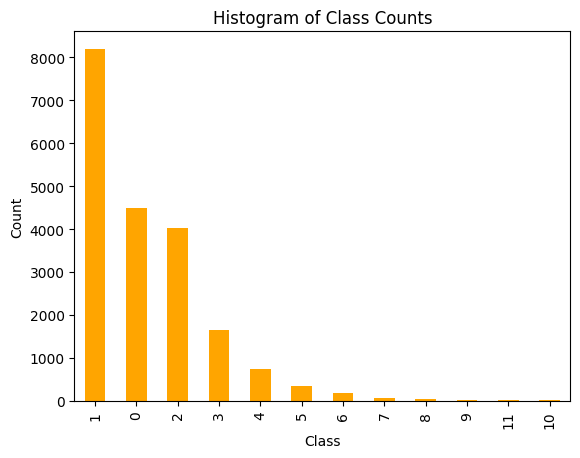

In [189]:
annotations_df['label'].value_counts().plot(kind='bar', color='Orange')
plt.title('Histogram of Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Milestone 2

In [7]:
def apply_gaussian_blur(image, radius):
    return image.filter(ImageFilter.GaussianBlur(radius=radius))

def apply_color_jitter(image, **kwargs):
    image_tensor = TF.to_tensor(image)
    image_tensor = TF.adjust_brightness(image_tensor, kwargs.get('brightness', 0))
    image_tensor = TF.adjust_contrast(image_tensor, kwargs.get('contrast', 0))
    image_tensor = TF.adjust_saturation(image_tensor, kwargs.get('saturation', 0))
    image_tensor = TF.adjust_hue(image_tensor, kwargs.get('hue', 0))
    image = TF.to_pil_image(image_tensor)

    return image

class CustomDataset(Dataset):
    def __init__(self, annotations_df, image_folder, transform=None, oversample_threshold=2000):
        self.dataframe = annotations_df
        self.image_folder = image_folder
        self.transform = transform
        self.num_classes = len(set(self.dataframe.iloc[:, 5]))
        self.class_counts = self.dataframe.iloc[:, 5].value_counts().to_dict()
        self.max_class_count = max(self.class_counts.values())
        self.min_class_count = min(self.class_counts.values())
        self.oversample_threshold = oversample_threshold
        self.oversampled_indices = self.oversample_minority_class()

    def __len__(self):
        return len(self.dataframe) + self.get_oversample_count()  # Adjusting length to include oversampled data

    def __getitem__(self, idx):
        if idx < len(self.dataframe):
            img_name = self.dataframe.iloc[idx, 0]
            img_path = os.path.join(self.image_folder, img_name)
            image = Image.open(img_path).convert("RGB")
            label = self.dataframe.iloc[idx, 5]
        else:
            oversampled_idx = idx - len(self.dataframe)
            oversampled_data_idx = self.oversampled_indices[oversampled_idx]
            img_name = self.dataframe.iloc[oversampled_data_idx, 0]
            img_path = os.path.join(self.image_folder, img_name)
            image = Image.open(img_path).convert("RGB")
            label = self.dataframe.iloc[oversampled_data_idx, 5]

        if self.transform:
            image = self.transform(image)

        return image, label
    
    def get_oversample_count(self):
        count = sum(1 for count in self.class_counts.values() if count < self.oversample_threshold)
        return count * (self.max_class_count - self.oversample_threshold)

    def oversample_minority_class(self):
        oversampled_indices=[]
        average_count = sum(self.class_counts.values()) // len(self.class_counts)
        for class_label, count in self.class_counts.items():
            if count < self.oversample_threshold:
                class_indices = self.dataframe.index[self.dataframe.iloc[:, 5] == class_label].tolist()
                oversample_count = average_count - count
                oversampled_indices.extend(random.choices(class_indices, k=oversample_count))
        self.dataframe = pd.concat([self.dataframe, self.dataframe.iloc[oversampled_indices]])       
        self.class_counts = self.dataframe.iloc[:, 5].value_counts().to_dict()  # Update class counts
        self.oversampled_indices = oversampled_indices  # Update oversampled indices
        return oversampled_indices
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.Lambda(lambda x: apply_gaussian_blur(x, 1)),
    transforms.Lambda(lambda x: apply_color_jitter(x, brightness=1, contrast=0.9, saturation=0.8, hue=0.3)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.455, 0.426, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = CustomDataset(annotations_df, image_folder=image_folder, transform=transform)
oversampled_indices = dataset.oversample_minority_class()  # Populate oversampled indices
print("Length of dataset after oversampling:", len(dataset))


Length of dataset after oversampling: 40406


In [8]:
from sklearn.model_selection import train_test_split
#train and test sets (80% train, 20% test)
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

#train set into train and validation sets (75% train, 25% validation)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)

from torch.utils.data import DataLoader
batch_size=64
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train DataLoader:


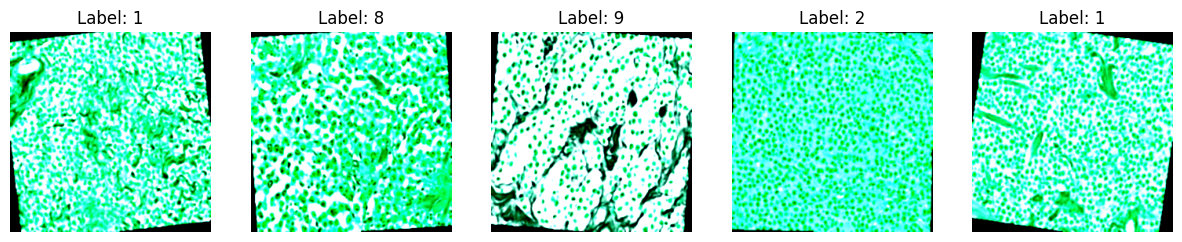

Validation DataLoader:


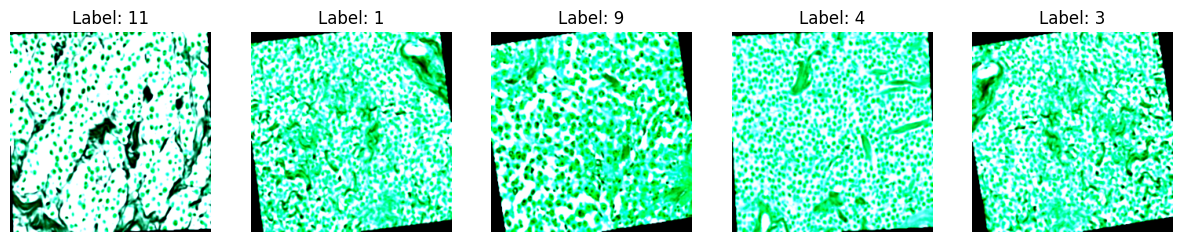

Test DataLoader:


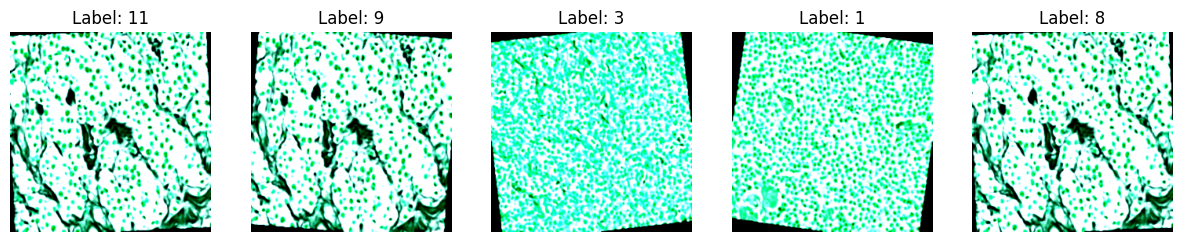

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_batch(loader, max_samples=5):
    
    images, labels = next(iter(loader))
    batch_size = len(images)
    num_samples = min(batch_size, max_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    # Plot each sample
    for i in range(num_samples):
        image = images[i].permute(1, 2, 0)
        label = labels[i]
        if num_samples == 1:
            axes.imshow(image)
            axes.set_title(f'Label: {label}')
            axes.axis('off')
        else:
            axes[i].imshow(image)
            axes[i].set_title(f'Label: {label}')
            axes[i].axis('off')

    plt.show()


print("Train DataLoader:")
visualize_batch(train_loader)

print("Validation DataLoader:")
visualize_batch(val_loader)

print("Test DataLoader:")
visualize_batch(test_loader)


In [10]:
#making model
import PIL
model = models.efficientnet_b0(weights=True)
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


C:\Users\laksh\anaconda3\envs\colenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
#optimizer-Adam
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
lr=0.001
#train loop
def train_loop(model, dataloader, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_batches = len(dataloader)
    with tqdm(total=total_batches, desc='Training') as pbar:
        for batch_idx, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 10 == 9: 
                avg_loss = running_loss / 10
#                 print(f'Batch [{batch_idx+1}/{total_batches}], Loss: {avg_loss:.4f}')
                running_loss = 0.0 

            pbar.update(1)  
    
    avg_epoch_loss = running_loss / total_batches
    
    return avg_epoch_loss

In [13]:
#validation loop
def validate_loop(model, dataloader, device):
    model.eval()  
    running_loss = 0.0
    total_batches = len(dataloader)
    all_preds = []
    all_labels = []  
    with torch.no_grad():
        with tqdm(total=total_batches, desc='Validation') as pbar:
            for batch_idx, (images, labels) in enumerate(dataloader):
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = F.cross_entropy(outputs, labels)
                running_loss += loss.item()
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

                pbar.update(1) 
        avg_epoch_loss = running_loss / total_batches
        accuracy = accuracy_score(all_labels, all_preds)

    return avg_epoch_loss, accuracy

In [14]:
# Optimization loop
def optimization_loop(model, train_loader, val_loader, device, n_epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}/{n_epochs}:")
        
        # Training phase
        train_loss = train_loop(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        print(f"Train Loss: {train_loss:.4f}")

        # Validation phase
        val_loss, val_acc = validate_loop(model, val_loader, device)
        val_losses.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'final_model.pth')
            print("Model saved!")
    plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

Epoch 1/1:


Training: 100%|██████████████████████████████████████████████████████████████████████| 379/379 [11:36<00:00,  1.84s/it]


Train Loss: 0.0514


Validation: 100%|████████████████████████████████████████████████████████████████████| 127/127 [03:49<00:00,  1.81s/it]


Validation Loss: 2.0503, Validation Accuracy: 0.2554
Model saved!


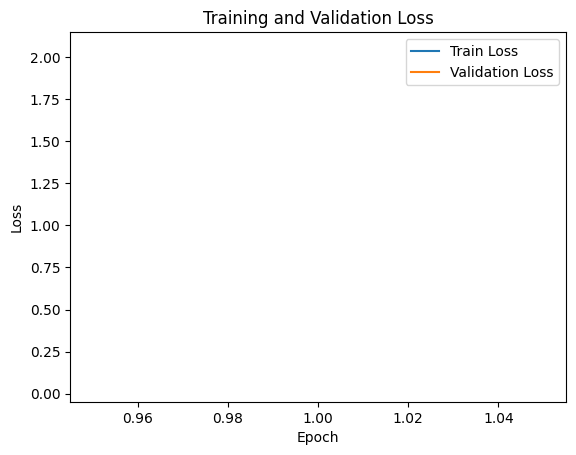

Final F1 Score: 0.1587


In [15]:
#testing loop
n_epochs=1
def test_model(model, test_loader, device):
    true_labels = []
    predicted_labels = []
    model.load_state_dict(torch.load('final_model.pth'))
    model.eval()

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        with torch.no_grad():
            outputs = model(images)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
    final_f1_score = f1_score(true_labels, predicted_labels, average='macro')
    print(f"Final F1 Score: {final_f1_score:.4f}")
    
#implementation    
optimization_loop(model, train_loader, val_loader, device, n_epochs, lr=0.001)
test_model(model, test_loader, device)

### Milestone 3

In [16]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, annotations_df, image_folder, num_samples, crop_size, transform=None, max_resample_attempts=10):
        self.dataframe = annotations_df
        self.image_folder = image_folder
        self.num_samples = num_samples
        self.crop_size = crop_size
        self.transform = transform
        self.max_resample_attempts = max_resample_attempts
        self.images = self.dataframe['filename'].unique()
        self.annotations = self.box_annotations()

    def box_annotations(self):
        grouped_annotations = {}
        for _, row in self.dataframe.iterrows():
            filename = row['filename']
            if filename not in grouped_annotations:
                grouped_annotations[filename] = []
            grouped_annotations[filename].append({
                'bbox': [row['min_x'], row['min_y'], row['max_x'], row['max_y']],
                'label': 1
            })
        return grouped_annotations

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        for _ in range(self.max_resample_attempts):
            img_idx = idx % len(self.images)
            img_name = self.images[img_idx]
            img_path = os.path.join(self.image_folder, img_name)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            annotations = self.annotations[img_name]
            image_height, image_width, _ = image.shape

            crop_x1 = random.randint(0, image_width - self.crop_size[0])
            crop_y1 = random.randint(0, image_height - self.crop_size[1])
            crop_x2 = crop_x1 + self.crop_size[0]
            crop_y2 = crop_y1 + self.crop_size[1]

            cropped_image = image[crop_y1:crop_y2, crop_x1:crop_x2]
            boxes = []
            labels = []

            for annotation in annotations:
                bbox = annotation['bbox']
                if bbox[0] < crop_x2 and bbox[2] > crop_x1 and bbox[1] < crop_y2 and bbox[3] > crop_y1:
                    bbox = [
                        max(bbox[0] - crop_x1, 0),
                        max(bbox[1] - crop_y1, 0),
                        min(bbox[2] - crop_x1, self.crop_size[0]),
                        min(bbox[3] - crop_y1, self.crop_size[1])
                    ]
                    boxes.append(bbox)
                    labels.append(1)  # All cells are labeled as 1

            if boxes:
                boxes = torch.as_tensor(boxes, dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.int64)
                image_id = torch.tensor([idx])

                target = {
                    'boxes': boxes,
                    'labels': labels,
                    'image_id': image_id,
                }

                if self.transform:
                    transformed = self.transform(image=cropped_image, bboxes=boxes, labels=labels)
                    cropped_image = transformed['image']
                    target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
                    target['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)

                cropped_image = cropped_image.float() / 255.0

                return cropped_image, target

        cropped_image = image[crop_y1:crop_y2, crop_x1:crop_x2]
        dummy_box = torch.as_tensor([[0, 0, 1, 1]], dtype=torch.float32)
        dummy_label = torch.as_tensor([1], dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {
            'boxes': dummy_box,
            'labels': dummy_label,
            'image_id': image_id,
        }

        if self.transform:
            transformed = self.transform(image=cropped_image, bboxes=dummy_box, labels=dummy_label)
            cropped_image = transformed['image']
            target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            target['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)

        cropped_image = cropped_image.float() / 255.0

        return cropped_image, target
    
    
# Albumentations transformation for object detection
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

num_samples = 100
crop_size = (240, 240)
dataset2 = ObjectDetectionDataset(annotations_df, image_folder, num_samples, crop_size, transform=transform)

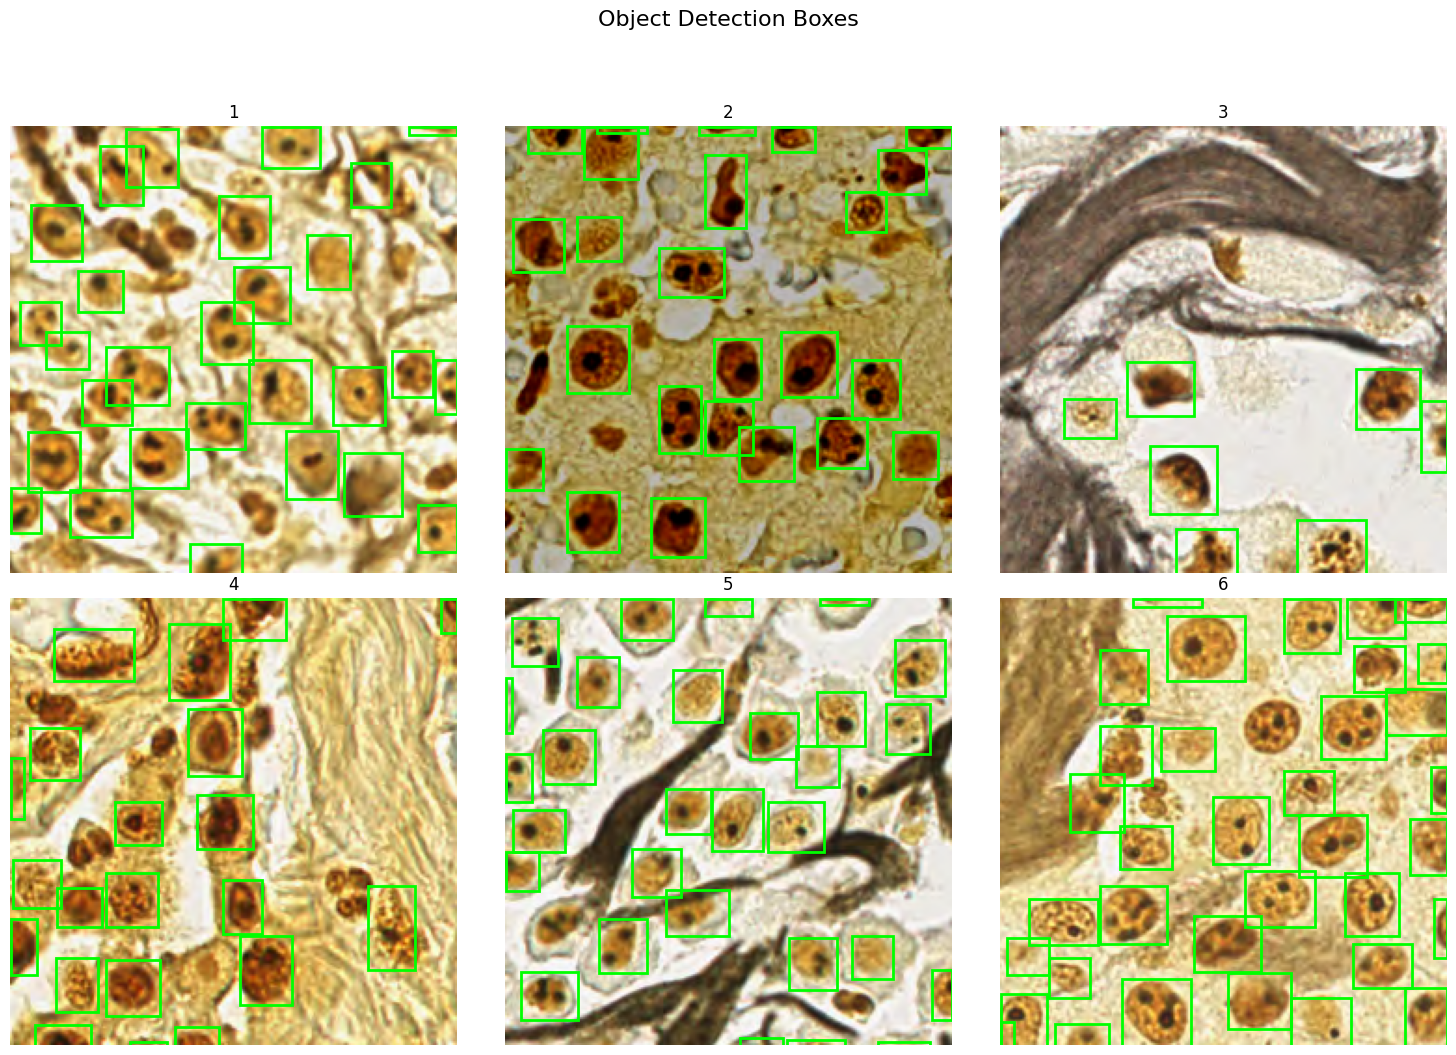

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visual(dataset, num_images=5, num_cols=3):
    num_rows = (num_images + num_cols - 1) // num_cols 
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    for i in range(num_images):
        image, target = dataset[i]
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(image.permute(1, 2, 0).numpy())  

        for box in target['boxes']:
            x_min, y_min, x_max, y_max = box.tolist() 
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle(
                (x_min, y_min), width, height, linewidth=2,
                edgecolor='lime', facecolor='none', linestyle='-'
            )
            ax.add_patch(rect)

        ax.set_title(i+1, fontsize=12)
        ax.axis('off')
    for j in range(i + 1, num_rows * num_cols):
        axes[j // num_cols, j % num_cols].axis('off')

    plt.suptitle('Object Detection Boxes', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()
    
visual(dataset2, num_images=6, num_cols=3)

In [125]:
# Spliting the data
train_size2 = int(0.8 * len(dataset2))
val_size2 = (len(dataset2) - train_size2) // 2
test_size2 = len(dataset2) - train_size2 - val_size2

train_dataset2, val_dataset2, test_dataset2 = torch.utils.data.random_split(
    dataset2, [train_size2, val_size2, test_size2], generator=torch.Generator().manual_seed(42)
)

train_loader2 = DataLoader(train_dataset2, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader2 = DataLoader(val_dataset2, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader2 = DataLoader(test_dataset2, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [126]:
# Initialize Model
model2 = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2

# number of input features for the classifier
in_features = model2.roi_heads.box_predictor.cls_score.in_features
model2.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model2 = model2.to(device)

C:\Users\laksh\anaconda3\envs\colenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\laksh\anaconda3\envs\colenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [127]:
# Optimizer
optimizer = optim.Adam(model2.parameters(), lr=0.001)
# Metrics
metric = MeanAveragePrecision(box_format='xyxy')

In [128]:
def train_loop2(model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, targets in tqdm(dataloader, desc="Training"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Training Loss: {avg_loss:.4f}")
    return avg_loss

def validate_loop2(model, dataloader, device, metric):
    model.train()  # Enable training mode to get losses
    running_loss = 0.0
    metric.reset()

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation"):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass for validation loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            running_loss += losses.item()

            
            model.eval()  # Switching to evaluation mode for inference
            outputs = model(images)
            model.train()  # Switching back to training mode for the next batch

            metric.update(outputs, targets)

    avg_loss = running_loss / len(dataloader)
    val_map = metric.compute()
    print(f"Validation Loss: {avg_loss:.4f}, mAP: {val_map['map']:.4f}")
    return avg_loss, val_map

In [129]:
num_epochs = 1
best_map = 0
train_losses = []
val_losses = []
val_map_scores = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train_loss = train_loop2(model2, train_loader2, optimizer, device)
    val_loss, val_map = validate_loop2(model2, val_loader2, device, metric)
    if val_map['map'] > best_map:
        best_map = val_map['map']
        torch.save(model2.state_dict(), 'best_model.pth')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_map_scores.append(val_map)

    print(f'Epoch {epoch + 1} completed. Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation mAP: {val_map["map"]:.4f}')

Epoch 1/1


Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [04:49<00:00, 28.98s/it]


Training Loss: 6.3943


Validation: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.79s/it]


Validation Loss: 2.2150, mAP: 0.0002
Epoch 1 completed. Training Loss: 6.3943, Validation Loss: 2.2150, Validation mAP: 0.0002


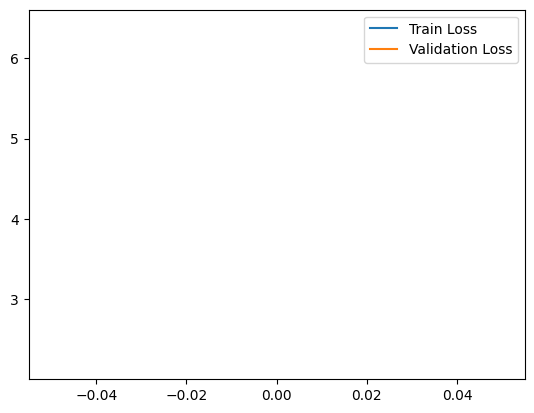

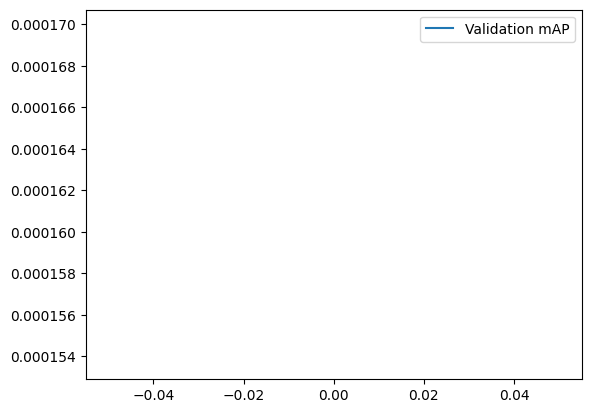

Training and evaluation completed.


In [130]:
# Ploting the training and validation losses
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot([v["map"] for v in val_map_scores], label='Validation mAP')
plt.legend()
plt.show()

print("Training and evaluation completed.")

### Milestone 4

In [175]:
def make_retinanet(path_to_weights: str):
    backbone = torchvision.models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).features
    backbone.out_channels = 1280
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    model = RetinaNet(backbone, num_classes=2, anchor_generator=anchor_generator)

    model.load_state_dict(torch.load(path_to_weights))
    model.eval()
    return model

In [176]:
path_to_weights = "C:\\Users\\laksh\\Downloads\\retinanet\\best_model_0.743_map.pth"
model2 = make_retinanet(path_to_weights)
model2 = model2.to(device)
model2.eval()

RetinaNet(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e

In [223]:
def ensure_pil_image(image):
    if isinstance(image, np.ndarray):
        return Image.fromarray(image)
    elif isinstance(image, Image.Image):
        return image
    else:
        raise TypeError("Unsupported image type")
        
def process_image(image, crop_size, overlap, model, detection_threshold):
    image = ensure_pil_image(image)
    width, height = image.size
    overlap = int(overlap * min(crop_size)) if isinstance(overlap, float) else overlap
    stride_x = crop_size[0] - overlap
    stride_y = crop_size[1] - overlap
    all_boxes = []
    all_scores = []
    model.eval()
    device = next(model.parameters()).device
    transform = transforms.ToTensor()

    with torch.no_grad():
        for y in range(0, height, stride_y):
            for x in range(0, width, stride_x):
                crop = image.crop((x, y, x + crop_size[0], y + crop_size[1]))
                input_tensor = transform(crop).unsqueeze(0).to(device)
                detections = model(input_tensor)[0]
                boxes = detections['boxes']
                scores = detections['scores']

                for i in range(len(boxes)):
                    if scores[i] >= detection_threshold:
                        box = boxes[i].cpu().numpy()
                        box[0] += x
                        box[1] += y
                        box[2] += x
                        box[3] += y
                        all_boxes.append(box)
                        all_scores.append(scores[i].cpu().item())  # Ensure scores are properly converted to items

    if all_boxes:
        all_boxes = torch.tensor(all_boxes, dtype=torch.float32)
        all_scores = torch.tensor(all_scores)
        keep = nms(all_boxes, all_scores, detection_threshold)
        all_boxes = all_boxes[keep].tolist()
        all_scores = all_scores[keep].tolist()

    return [{'boxes': box, 'scores': score} for box, score in zip(all_boxes, all_scores)]

In [224]:
def process_cells(image, coords, model, crop_size):
    image = ensure_pil_image(image)
    model.eval()
    device = next(model.parameters()).device
    transform = transforms.Compose([
        transforms.Resize(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    labels = []
    predictions = []

    with torch.no_grad():
        for coord in coords:
            box = coord['boxes']
            x1, y1, x2, y2 = map(int, box)
            crop = image.crop((x1, y1, x2, y2))
            crop = transform(crop).unsqueeze(0).to(device)
            output = model(crop)
            _, predicted = torch.max(output, 1)
            label = predicted.item()
            labels.append(label)
            predictions.append(output.cpu().numpy())

    agnor_score = sum(labels) / len(labels) if labels else 0
    return labels, agnor_score


In [225]:
def compute_AgNOR_score(image, detection_model, classification_model, crop_size, overlap, detection_threshold):
    detected_coords = process_image(image, crop_size, overlap, detection_model, detection_threshold)
    labels, agnor_score = process_cells(image, detected_coords, classification_model, crop_size)
    return labels, agnor_score

In [226]:
def test_pipeline(annotations_df, image_folder, detection_model, classification_model, crop_size, overlap, detection_threshold):
    all_images = annotations_df['filename'].unique()
    images = random.sample(list(all_images), 5)
    results = []

    for image_filename in images:
        image_path = os.path.join(image_folder, image_filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        labels, predicted_agnor_score = compute_AgNOR_score(
            image,
            detection_model,
            classification_model,
            crop_size,
            overlap,
            detection_threshold
        )

        image_annotations = annotations_df[annotations_df['filename'] == image_filename]
        true_agnor_score = image_annotations['label'].mean()

        results.append({
            'filename': image_filename,
            'predicted_agnor_score': predicted_agnor_score,
            'true_agnor_score': true_agnor_score
        })

    results_df = pd.DataFrame(results)
    error = mean_absolute_error(results_df['true_agnor_score'], results_df['predicted_agnor_score'])
    return results_df, error

In [222]:
results_df, error = test_pipeline(
    annotations_df,
    image_folder,
    detection_model=model2,
    classification_model=model,
    crop_size=(240, 240),
    overlap=32,
    detection_threshold=0.9
)
print(results_df)
print(f'Mean Absolute Error: {error}')


          filename  predicted_agnor_score  true_agnor_score
0  AgNOR_0495.tiff               1.000000          1.357864
1  AgNOR_0531.tiff               0.000000          1.081529
2  AgNOR_0519.tiff             193.933333          1.482927
3  AgNOR_2852.tiff               1.000000          3.779874
4  AgNOR_2783.tiff               1.000000          0.695968
Mean Absolute Error: 39.39474119925016
